# 02. Integrator

本章主要讲述了连续系统的离散化问题，对应国内《计算机控制系统》课程中“差分法离散”的内容。

In [46]:
import numpy as np
from typing import Callable, Tuple

def pendulum_dynamics(x: np.ndarray) -> np.ndarray:
    l = 1.0
    g = 9.8

    q = x[0]
    v = x[1]

    a = -(g / l) * np.sin(q)

    return np.array([v, a])


## 1. 前向差分法

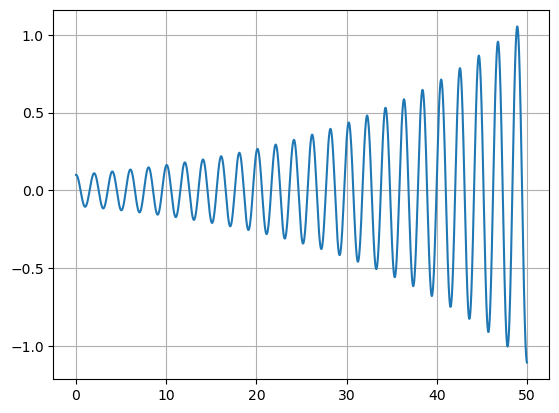

In [47]:
import matplotlib.pyplot as plt

def pendulum_forward_euler(
        func: Callable[[np.ndarray], np.ndarray], 
        x0: np.ndarray, 
        Tf: float, 
        h: float) -> Tuple[np.ndarray, np.ndarray]:
    
    t = np.arange(0, Tf, h)

    x_history = np.zeros((len(x0), len(t)))
    x_history[:, 0] = x0

    for k in range(len(t) - 1):
        x_history[:, k+1] = x_history[:, k] + h * func(x_history[:, k])
    
    return x_history, t

x0 = np.array([0.1, 0])
x_history, t = pendulum_forward_euler(pendulum_dynamics, x0, 50, 0.01)

plt.plot(t, x_history[0, :])
plt.grid(True)
plt.show()


In [48]:
def pendulum_euler_Ad(x0: np.ndarray, h: float) -> np.ndarray:
    l = 1.0
    g = 9.8
    Ad = np.array([[1, h], [-(g / l) * h * np.cos(x0[0]), 1]])
    return Ad

np.linalg.eigvals(pendulum_euler_Ad(np.array([0]), 0.01))

array([1.+0.03130495j, 1.-0.03130495j])

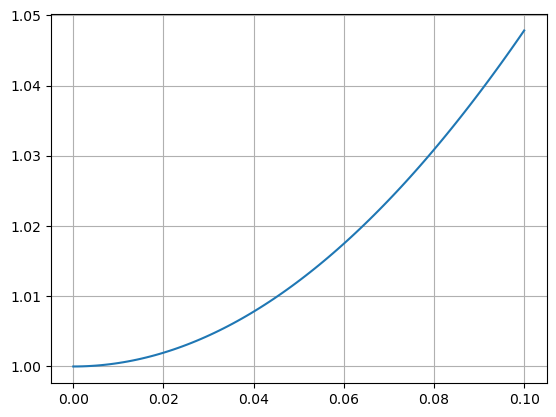

In [49]:
eignorm = np.zeros((100,))
h = np.linspace(0, 0.1, 100)
for k in range(len(eignorm)):
    eigvals = np.linalg.eigvals(pendulum_euler_Ad(np.array([0]), h[k]))
    eignorm[k] = np.linalg.norm(eigvals, ord=np.inf)

plt.plot(h, eignorm)
plt.grid(True)
plt.show()

## 2. 四阶Runge-Kutta近似

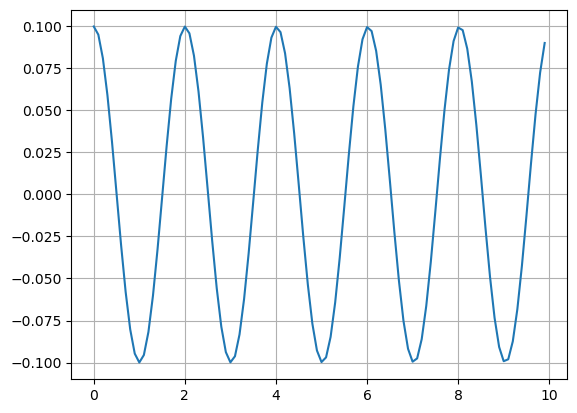

In [50]:
def fd_pendulum_rk4(xk: np.ndarray, h: float) -> np.ndarray:
    f1 = pendulum_dynamics(xk)
    f2 = pendulum_dynamics(xk + 0.5 * h * f1)
    f3 = pendulum_dynamics(xk + 0.5 * h * f2)
    f4 = pendulum_dynamics(xk + h * f3)
    return xk + (h / 6.0) * (f1 + 2 * f2 + 2 * f3 + f4)


def pendulum_rk4(x0: np.ndarray, Tf: float, h: float) -> Tuple[np.ndarray, np.ndarray]: 
    
    t = np.arange(0, Tf, h)

    x_history = np.zeros((len(x0), len(t)))
    x_history[:, 0] = x0

    for k in range(len(t) - 1):
        x_history[:, k + 1] = fd_pendulum_rk4(x_history[:, k], h)
    
    return x_history, t


x0 = np.array([0.1, 0])
x_history, t = pendulum_rk4(x0, 10, 0.1)

plt.plot(t, x_history[0,:])
plt.grid(True)
plt.show()


In [51]:
# 这里使用有限差分做近似梯度计算
def forward_diff(
        func: Callable[[np.ndarray, float], np.ndarray],
        x: np.ndarray, 
        h: float) -> np.ndarray:
    
    eps = np.finfo(np.float64).eps
    
    x_copy = x.copy()
    x_copy[0] += eps
    d1 = (func(x_copy, h) - func(x, h)) / eps

    x_copy[0] -= eps
    x_copy[1] += eps
    d2 = (func(x_copy, h) - func(x, h)) / eps

    res = np.zeros((2, 2))
    res[0, :] = d1
    res[1, :] = d2

    return res


Ad = forward_diff(fd_pendulum_rk4, np.array([0.0, 0.0]), 0.1)
np.linalg.norm(np.linalg.eigvals(Ad), ord=np.inf)


0.9999935439902851

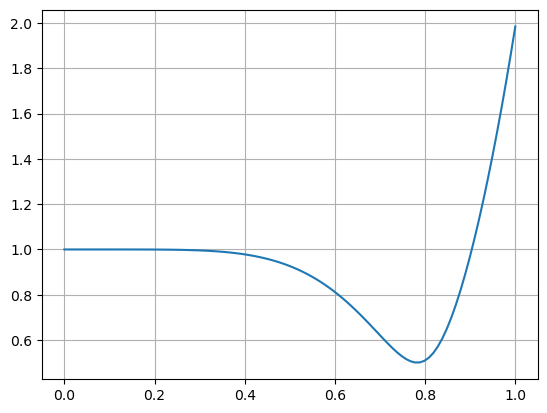

In [52]:

eignorm = np.zeros((100,))
h = np.linspace(0, 1, 100)
for k in range(len(eignorm)):
    Ad = forward_diff(fd_pendulum_rk4, np.array([0.0, 0.0]), h[k])
    eignorm[k] = np.linalg.norm(np.linalg.eigvals(Ad), ord=np.inf)

plt.plot(h, eignorm)
plt.grid(True)
plt.show()


## 3. 后向差分法

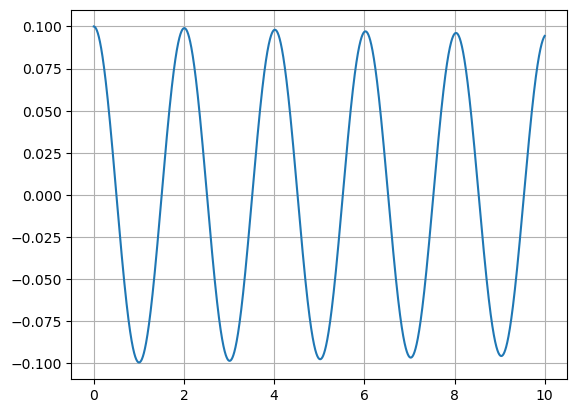

In [53]:
def pendulum_backward_euler(func, x0, Tf, dt):
    t = np.arange(0, Tf, step=dt)
    
    x_history = np.zeros((len(x0), len(t)))
    x_history[:, 0] = x0
    
    for k in range(len(t) - 1):
        e = 1
        x_history[:, k+1] = x_history[:, k]
        while e > 1e-8:
            xn = x_history[:, k] + dt * func(x_history[:, k+1])
            e = np.linalg.norm(xn - x_history[:, k+1], ord=np.inf)
            x_history[:, k + 1] = xn
    
    return x_history, t

x0 = np.array([0.1, 0])
x_history, t = pendulum_backward_euler(pendulum_dynamics, x0, 10, 0.001)

plt.plot(t, x_history[0, :])
plt.grid(True)
plt.show()
